In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn-white')
# colorblind safe
plt.style.use('seaborn-colorblind')
plt.style.use('tableau-colorblind10')

# width and precision for f strings
width = 10
precision = 4

# default sizes for plots
# https://matplotlib.org/3.3.0/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

# other settings
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.precision", 3)
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)
%config IPCompleter.greedy=True


In [2]:
import os
G_MAPS_API = os.environ.get("GOOGLE_STATICMAPS_API")

In [3]:
import random, time

In [4]:
import googlemaps

In [5]:
gmaps = googlemaps.Client(G_MAPS_API)

In [6]:
n_requests = 0

In [22]:
def download_images(client, df, zoomlevel, max_requests=10, prefix="", out_path="data/"):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    global n_requests
    
    for i, site in df.iterrows():
        print(f'Pulling image {i}, total API requests so far = {n_requests}')
        #print(f"{site['Latitude']}, {site['Longitude']}")
        
        # temp save coords
        lat = site['Latitude']
        long = site['Longitude']
        
        # and tags for site
        cat = site['Category']
        
        # create filename
        cur_filename = f'satimg_{prefix}_{i}_{cat}_{zoomlevel}_{lat}_{long}.png'
        print(cur_filename)

        # if it already exists, skip to next
        if os.path.exists(out_path + cur_filename):
            continue

        # get the image
        satimg = client.static_map(size = (400, 400), # pixels
           zoom = zoomlevel, # 1-21
           center = (lat, long),
           scale = 1, # default is 1, 2 returns 2x pixels for high res displays
           maptype = "satellite",
           format = "png"
          )
        
        # if it didn't work, exit
        if satimg is None or n_requests >= max_requests:
            print("API requests quota exceeded!")    
            break
        # increase counter otherwise
        n_requests += 1
        
        # save the current image
        f = open(out_path + cur_filename, 'wb')
        for chunk in satimg:
            if chunk:
                f.write(chunk)
        f.close()
        
        # open it to crop the text off
        img = plt.imread(out_path + cur_filename)
        # maybe crop all 4 sides?
        cropped = img[25:375, 25:375]
        # and resave
        #cropped_filename = f'satimg_{i}_{cat}_{zoomlevel}_{lat}_{long}.png'
        plt.imsave(out_path + cur_filename, cropped)
        
        # and rotate and save that version
        for k, degrees in enumerate([90, 180, 270]):
            #print(k, degrees)
            cropped_rotated = np.rot90(cropped, k=k)
            cropped_rot_filename = f'satimg_{prefix}_{i}_{cat}_{zoomlevel}_{lat}_{long}_rot{degrees}.png'
            #print(cropped_rot_filename)
            plt.imsave(out_path + cropped_rot_filename, cropped_rotated)
        
        # and zoom in and save
#         zoomed = img[100:300, 100:300]
#         zoomed_cropped_filename = f'satimg_{i}_{cat}_{zoomlevel}_zoomed_{lat}_{long}.png'
#         plt.imsave(out_path + zoomed_cropped_filename, zoomed)
        
#         # and rotate on zoom in and save
#         zoomed_rot = np.rot90(zoomed)
#         zoomed_cropped_rot_filename = f'satimg_{i}_{cat}_{zoomlevel}_zoomed_rot90_{lat}_{long}.png'
#         plt.imsave(out_path + zoomed_cropped_rot_filename, zoomed_rot)
        
        # wait a bit before next request
        wait_time = random.randint(1, 5)
        print(f'waiting for: {wait_time} seconds')
        time.sleep(wait_time) # in seconds

        # display samples every now and then
        if i % 100 == 0:
            img = plt.imread(out_path + cur_filename)
            plt.imshow(img)
            plt.title(f'image {i}')
            plt.show()
            time.sleep(2)
    return True

In [7]:
USdata_cleaned = pd.read_csv('data/USdata_zip_states_combined_cleaned.csv')

In [10]:
categories = list(USdata_cleaned['Category'].unique())
categories

['Wild Camping',
 'Informal Campsite',
 'Showers',
 'Water',
 'Short-term Parking',
 'Eco-Friendly']

In [11]:
USdata_CO = USdata_cleaned[USdata_cleaned['State'] == 'CO'].copy()

In [16]:
USdata_CO.groupby('Category').agg('count')['Description']

Category
Eco-Friendly            6
Informal Campsite     107
Short-term Parking      1
Showers                13
Water                  28
Wild Camping          395
Name: Description, dtype: int64

In [ ]:
# maybe do this by category and put into different folders?

In [24]:
max_requests = 1000

In [17]:
out_path=f"data/sites_CO/{category}/"

In [20]:
USdata_CO = USdata_CO.reset_index()

In [21]:
USdata_CO.head()

,index,Location,Name,Category,Description,Latitude,Longitude,Altitude,Date verified,Open,Electricity,Wifi,Kitchen,Parking,Restaurant,Showers,Water,Toilets,Big rig friendly,Tent friendly,Pet friendly,Sanitation dump station,Outdoor gear,Groceries,Artesian goods,Bakery,Rarity in this area,Repairs vehicles,Repairs motorcycles,Repairs bicycles,Sells parts,Recycles batteries,Recycles oil,Bio fuel,Electric vehicle charging,Composting sawdust,Recycling center,zip_code,State
0,6,NaN,Sauls Creek,Wild Camping,National Forest Service open camping. Many pul...,37.2381,-107.5242,"2,175.0000",2018-09-08 00:00:00 UTC,Yes,No,No,No,nan,No,No,No,No,No,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81122,CO
1,21,NaN,"Lizard Head Pass Dispersed Camping, Telluride,...",Wild Camping,Next to the Lizard Head Pass with stunning vie...,37.8130,-107.9055,"3,110.5248",2020-08-19 00:00:00 UTC,Yes,No,No,No,nan,No,No,No,Pit Toilets,Yes,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81426,CO
2,94,NaN,Colorado Welcome Center,Informal Campsite,RV Parking behind Welcome Center.\nGraveled si...,40.2452,-109.0090,"1,799.1502",2019-07-25 00:00:00 UTC,Yes,No,Unknown,No,nan,No,No,No,No,Yes,Unknown,Unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81610,CO
3,113,NaN,Walden Visitor Info Free Camp,Informal Campsite,Dirt/gravel parking lot between visitor info a...,40.7270,-106.2872,"2,442.0334",2017-10-25 00:00:00 UTC,Yes,No,No,No,nan,No,No,No,Pit Toilets,Yes,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,80480,CO
4,119,NaN,Stone Quarry Road Free Camp “Take Out”,Wild Camping,A kind of dirt parking spot just between the r...,39.3952,-108.1061,"1,502.4187",2020-08-06 00:00:00 UTC,Yes,No,No,No,nan,No,No,Natural Source,No,No,Yes,Yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,81635,CO


Wild Camping
Pulling image 0, total API requests so far = 0
satimg_CO__0_Wild Camping_17_37.238067_-107.524203.png
waiting for: 3 seconds


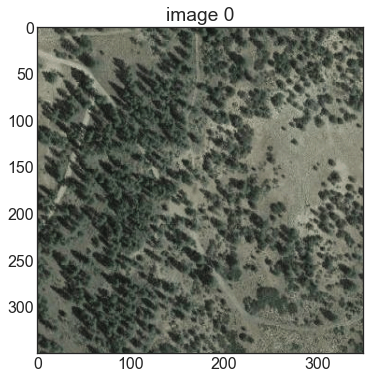

Pulling image 1, total API requests so far = 1
satimg_CO__1_Wild Camping_17_37.812975_-107.905482.png
waiting for: 5 seconds
Pulling image 4, total API requests so far = 2
satimg_CO__4_Wild Camping_17_39.39521_-108.106147.png
waiting for: 2 seconds
Pulling image 5, total API requests so far = 3
satimg_CO__5_Wild Camping_17_38.838421_-107.517971.png
waiting for: 3 seconds
Pulling image 9, total API requests so far = 4
satimg_CO__9_Wild Camping_17_39.307964_-108.702567.png
waiting for: 1 seconds
Pulling image 10, total API requests so far = 5
satimg_CO__10_Wild Camping_17_39.092332_-108.808072.png
waiting for: 4 seconds
Pulling image 11, total API requests so far = 6
satimg_CO__11_Wild Camping_17_38.776797_-108.288448.png
waiting for: 5 seconds
Pulling image 13, total API requests so far = 7
satimg_CO__13_Wild Camping_17_39.368473_-106.786083.png
waiting for: 2 seconds
Pulling image 14, total API requests so far = 8
satimg_CO__14_Wild Camping_17_40.244703_-104.05243.png
waiting for: 4 se

waiting for: 4 seconds
Pulling image 86, total API requests so far = 66
satimg_CO__86_Wild Camping_17_39.8346_-106.05345.png
waiting for: 2 seconds
Pulling image 87, total API requests so far = 67
satimg_CO__87_Wild Camping_17_39.01828_-105.18099.png
waiting for: 2 seconds
Pulling image 90, total API requests so far = 68
satimg_CO__90_Wild Camping_17_39.772194_-105.762246.png
waiting for: 5 seconds
Pulling image 93, total API requests so far = 69
satimg_CO__93_Wild Camping_17_39.100859_-106.368014.png
waiting for: 2 seconds
Pulling image 94, total API requests so far = 70
satimg_CO__94_Wild Camping_17_39.151353_-106.425406.png
waiting for: 3 seconds
Pulling image 95, total API requests so far = 71
satimg_CO__95_Wild Camping_17_40.165868_-105.457831.png
waiting for: 4 seconds
Pulling image 96, total API requests so far = 72
satimg_CO__96_Wild Camping_17_40.139004_-106.105506.png
waiting for: 4 seconds
Pulling image 97, total API requests so far = 73
satimg_CO__97_Wild Camping_17_39.2467

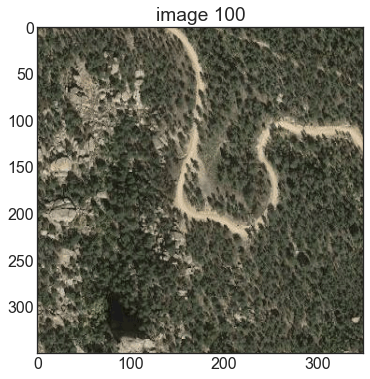

Pulling image 105, total API requests so far = 77
satimg_CO__105_Wild Camping_17_38.06261_-107.66027.png
waiting for: 3 seconds
Pulling image 106, total API requests so far = 78
satimg_CO__106_Wild Camping_17_38.53206_-102.52848.png
waiting for: 2 seconds
Pulling image 108, total API requests so far = 79
satimg_CO__108_Wild Camping_17_37.75222_-107.97693999999998.png
waiting for: 2 seconds
Pulling image 109, total API requests so far = 80
satimg_CO__109_Wild Camping_17_37.66889000000001_-108.32528.png
waiting for: 3 seconds
Pulling image 110, total API requests so far = 81
satimg_CO__110_Wild Camping_17_38.04722_-107.80917.png
waiting for: 2 seconds
Pulling image 111, total API requests so far = 82
satimg_CO__111_Wild Camping_17_38.92778_-107.27472.png
waiting for: 1 seconds
Pulling image 112, total API requests so far = 83
satimg_CO__112_Wild Camping_17_38.972505_-103.460771.png
waiting for: 5 seconds
Pulling image 113, total API requests so far = 84
satimg_CO__113_Wild Camping_17_37.

In [ ]:
for category in categories:
    print(category)
    tempdf = USdata_CO[USdata_CO['Category'] == category]
    #tempdf.info()
    download_images(gmaps, tempdf, max_requests=max_requests, zoomlevel=17, prefix="CO_", out_path=f"data/sites_CO/{category}/")